<b>Data mining project - 2020/21</b><br>
<b>Author</b>: [Alexandra Bradan](https://github.com/alexandrabradan)<br>
<b>Python version</b>: 3.x<br>
<b>Last update: 07/01/2021<b>

In [1]:
%matplotlib inline

# general libraries
import sys
import math
import operator
import itertools
import collections
from pylab import MaxNLocator
from collections import Counter
from collections import defaultdict
from IPython.display import Image

# pandas libraries
import pandas as pd
from pandas import DataFrame
from pandas.testing import assert_frame_equal

# visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt

# numpy libraries
import numpy as np
from numpy import std
from numpy import mean
from numpy import arange
from numpy import unique
from numpy import percentile

# scipy libraries
import scipy.stats as stats
from scipy.stats import kstest
from scipy.stats import normaltest

# sklearn libraries
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.experimental import enable_iterative_imputer  # explicitly require this experimental feature
from sklearn.impute import IterativeImputer

from sklearn import tree
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.pipeline import make_pipeline as imbmake_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, recall_score, precision_score, classification_report, roc_auc_score 

In [2]:
data_directory = "../../../data/"
plot_directory = "../../../plots/DataUnderstanding/"
TR_cleaned_file = data_directory + "Cleaned_Train_HR_Employee_Attrition.csv"
TS_file = data_directory + "One_Hot_Encoding_Test_HR_Employee_Attrition.csv"

In [3]:
df_cleaned = pd.read_csv(TR_cleaned_file, sep=",") 
df_ts = pd.read_csv(TS_file, sep=",") 

In [4]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 36 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Age                                     883 non-null    int64  
 1   Attrition                               883 non-null    int64  
 2   BusinessTravel_Non-Travel               883 non-null    int64  
 3   BusinessTravel_Travel_Rarely            883 non-null    int64  
 4   BusinessTravel_Travel_Frequently        883 non-null    int64  
 5   DistanceFromHome                        883 non-null    int64  
 6   Education                               883 non-null    int64  
 7   EnvironmentSatisfaction                 883 non-null    int64  
 8   Gender                                  883 non-null    int64  
 9   JobInvolvement                          883 non-null    int64  
 10  JobLevel                                883 non-null    int64 

In [5]:
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 37 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Age                                     219 non-null    int64  
 1   Attrition                               219 non-null    int64  
 2   BusinessTravel_Non-Travel               219 non-null    int64  
 3   BusinessTravel_Travel_Rarely            219 non-null    int64  
 4   BusinessTravel_Travel_Frequently        219 non-null    int64  
 5   DistanceFromHome                        219 non-null    int64  
 6   Education                               219 non-null    int64  
 7   EnvironmentSatisfaction                 219 non-null    int64  
 8   Gender                                  219 non-null    int64  
 9   JobInvolvement                          219 non-null    int64  
 10  JobLevel                                219 non-null    int64 

In [6]:
del df_ts["JobRole_Manager"]

<h2> Discretisation approach </h2> 
Approaches to transform continuous variables into discrete ones. This process is also known as <b>binning</b>, with each bin being each interval. Discretization methods fall into 2 categories: 

- supervised: do not use any information, other than the variable distribution, to create the contiguous bins in which the values will be placed;
- unsupervised: typically use target information in order to create bins or intervals.

Since we are dealying with DT it is natural to use a **supervised discretisation method** with them:

<u>Step 1</u>: First it trains a decision tree of limited depth (2, 3 or 4) using the variable we want to discretize to predict the target;

<u>Step 2</u>: The original variable values are then replaced by the probability returned by the tree. The probability is the same for all the observations within a single bin, thus replacing by the probability is equivalent to grouping the observations within the cut-off decided by the decision tree.

**Advantages** :
- The probabilistic predictions returned decision tree are monotonically related to the target.
- The new bins show decreased entropy, this is the observations within each bucket/bin are more similar to themselves than to those of other buckets/bins.
- The tree finds the bins automatically.

**Disadvantages**:
- It may cause over-fitting
- More importantly, some tuning of tree parameters might need to be done to obtain the optimal splits (e.g., depth, the minimum number of samples in one partition, the maximum number of partitions, and a minimum information gain). This it can be time-consuming.

<u>Features to discretize</u>:
- Age
- DistanceFromHome
- YearsAtCompany
- YearsInCurrentRole
- NumCompaniesWorked
- MonthlyIncome
- MonthlyHours

- PercentSalaryHike
- TaxRate

In [7]:
X_train = df_cleaned.copy()
X_test = df_ts.copy()

In [8]:
def estimate_column_best_k(column_name):
    sse= []
    silhouette = []
    for k in range(2, 21):
        kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
        kmeans.fit(X_train[[column_name]]) # performing K-means clustering

        sse.append(kmeans.inertia_) # storing the distorsion values
        silhouette.append(silhouette_score(X_train[[column_name]], kmeans.labels_)) # storing the silhouette scores
    # draw_sse_and_silhouette
    f, axs = plt.subplots(nrows=2, figsize=(15,5))
    plt.subplots_adjust(hspace=0.5)
    axs[0].plot(range(2, len(sse[0:13]) + 2), sse[0:13])
    axs[0].set_title('Sum Sqared Error for k = 2...12')
    axs[0].set_ylabel('SEE')
    axs[1].set_xlabel('K')

    axs[1].plot(range(2, len(silhouette[0:13]) + 2), silhouette[0:13])
    axs[1].set_title('Silhouette Score for k = 2...12')
    axs[1].set_ylabel('SIL')
    axs[0].set_xlabel('K')

In [9]:
def print_performed_encoding(column_name, train_encoded):
    column_index = df_cleaned.columns.get_loc(column_name)
    encoding_info = {}
    for enc, i in zip(train_encoded, range(0, len(train_encoded))):
        try:
            tmp_list = encoding_info[str(enc)]
            tmp_list.append(df_cleaned.iloc[i, column_index])
            encoding_info[str(enc)] = tmp_list
        except KeyError:
            encoding_info[str(enc)] = [df_cleaned.iloc[i, column_index]]
            
    for key, value in encoding_info.items():
        min_value = min(value)
        max_value = max(value)
        print(column_name, key, "[%s-%s]" %(min_value, max_value),sep="\t")

In [10]:
def kmeans_discretizer(column_name, best_k):
    discretizer = KBinsDiscretizer(n_bins=best_k, encode='ordinal', strategy='kmeans').fit(X_train[[column_name]])
    train_encoded = discretizer.transform(X_train[[column_name]]).astype(int)
    test_encoded = discretizer.transform(X_test[[column_name]]).astype(int)
    X_train[column_name] = train_encoded
    X_test[column_name] = test_encoded
    print_performed_encoding(column_name, train_encoded)

<h6>Age </h6>
Build a classification tree using the Age to predict Attrition in order to discretise the age variable

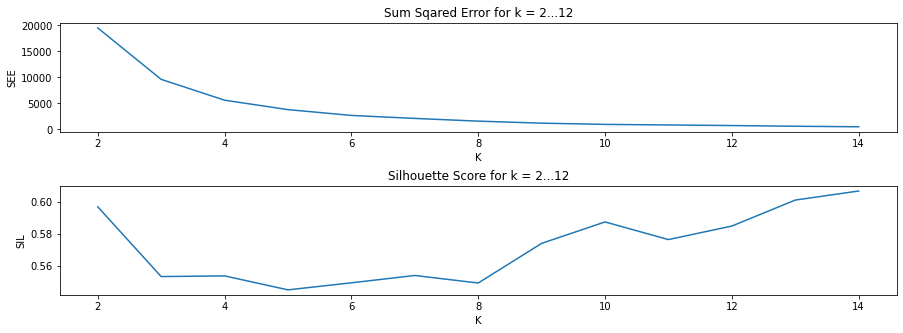

In [11]:
column_name = "Age"
estimate_column_best_k(column_name)

In [12]:
# best_k = 12
best_k = 6
kmeans_discretizer(column_name, best_k)

Age	[4]	[47-52]
Age	[2]	[33-39]
Age	[0]	[18-26]
Age	[1]	[27-32]
Age	[3]	[40-46]
Age	[5]	[53-60]


<h6>DistanceFromHome </h6>
Build a classification tree using the variable to predict Attrition in order to discretise it

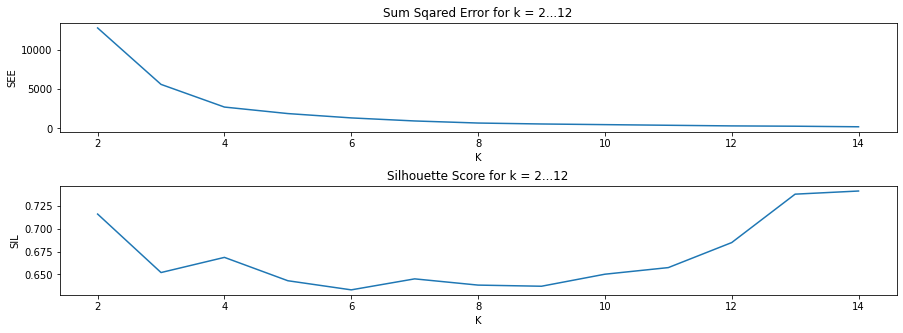

In [13]:
column_name = "DistanceFromHome"
estimate_column_best_k(column_name)

In [14]:
# best_k = 12
best_k = 6
kmeans_discretizer(column_name, best_k)

DistanceFromHome	[1]	[6-10]
DistanceFromHome	[0]	[1-5]
DistanceFromHome	[3]	[16-19]
DistanceFromHome	[5]	[25-29]
DistanceFromHome	[2]	[11-15]
DistanceFromHome	[4]	[20-24]


<h6> YearsAtCompany </h6>

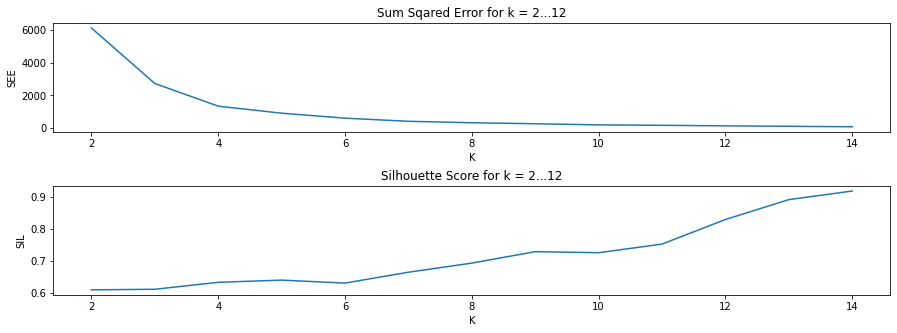

In [15]:
column_name = "YearsAtCompany"
estimate_column_best_k(column_name)

In [16]:
# best_k = 12
best_k = 5
kmeans_discretizer(column_name, best_k)

YearsAtCompany	[2]	[8-11]
YearsAtCompany	[0]	[0-3]
YearsAtCompany	[1]	[4-7]
YearsAtCompany	[3]	[12-16]
YearsAtCompany	[4]	[17-20]


<h6> YearsInCurrentRole </h6>

/home/alexandra/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: ConvergenceWarning: Number of distinct clusters (17) found smaller than n_clusters (18). Possibly due to duplicate points in X.
  
/home/alexandra/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: ConvergenceWarning: Number of distinct clusters (17) found smaller than n_clusters (19). Possibly due to duplicate points in X.
  
/home/alexandra/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: ConvergenceWarning: Number of distinct clusters (17) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  


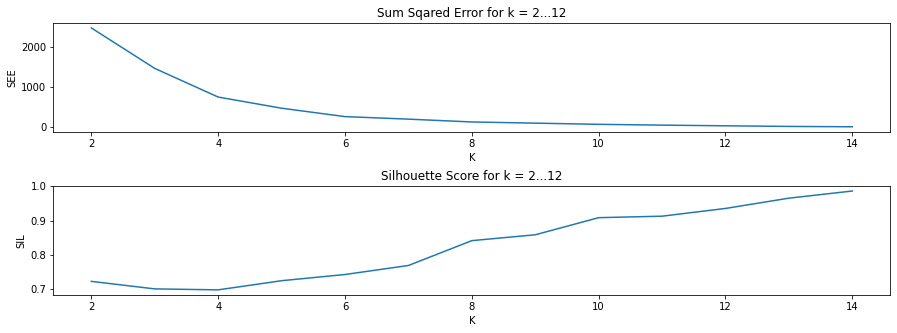

In [17]:
column_name = "YearsInCurrentRole"
estimate_column_best_k(column_name)

In [18]:
# best_k = 9
best_k = 4
kmeans_discretizer(column_name, best_k)

YearsInCurrentRole	[1]	[5-8]
YearsInCurrentRole	[0]	[0-4]
YearsInCurrentRole	[2]	[9-12]
YearsInCurrentRole	[3]	[13-16]


<h6> NumCompaniesWorked </h6>

/home/alexandra/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  
/home/alexandra/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  
/home/alexandra/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (13). Possibly due to duplicate points in X.
  
/home/alexandra/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (14). Possibly due to duplicate points in X.
  
/home/alexandra/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (15). Possibl

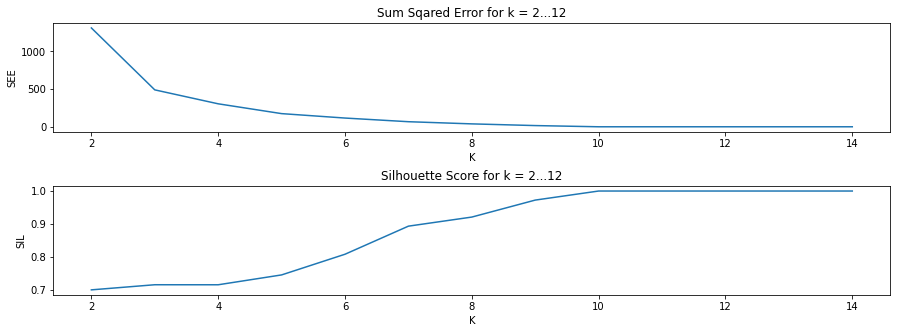

In [19]:
column_name = "NumCompaniesWorked"
estimate_column_best_k(column_name)

In [20]:
# best_k = 7
best_k = 2
kmeans_discretizer(column_name, best_k)

NumCompaniesWorked	[1]	[5-9]
NumCompaniesWorked	[0]	[0-4]


<h6> MonthlyIncome </h6>

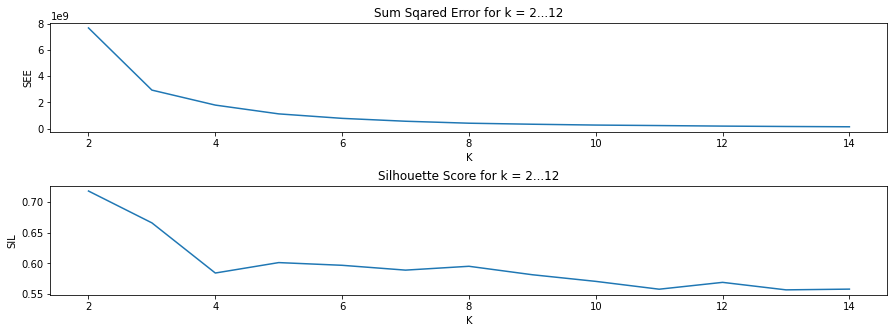

In [21]:
column_name = "MonthlyIncome"
estimate_column_best_k(column_name)

In [22]:
# best_k = 3
best_k = 11
kmeans_discretizer(column_name, best_k)

MonthlyIncome	[3]	[7551-9755]
MonthlyIncome	[1]	[3622-5441]
MonthlyIncome	[0]	[1009-3600]
MonthlyIncome	[2]	[5460-7547]
MonthlyIncome	[5]	[12069-14506]
MonthlyIncome	[6]	[14864-17491]
MonthlyIncome	[4]	[9888-11994]
MonthlyIncome	[10]	[24907-26997]
MonthlyIncome	[9]	[22670-24624]
MonthlyIncome	[7]	[17689-19630]
MonthlyIncome	[8]	[19921-22052]


<h6> MonthlyHours </h6>

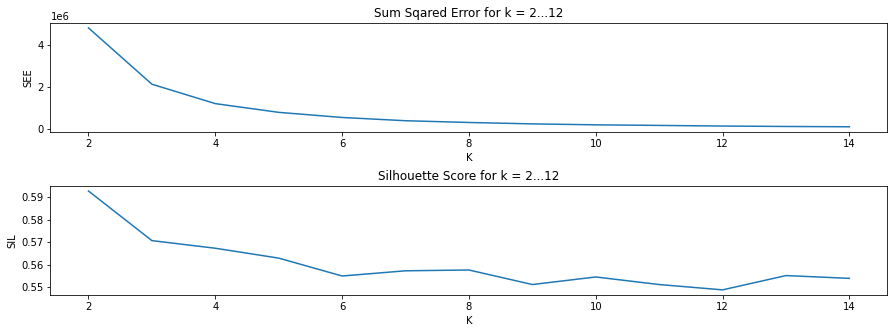

In [23]:
column_name = "MonthlyHours"
estimate_column_best_k(column_name)

In [24]:
best_k = 3
kmeans_discretizer(column_name, best_k)

MonthlyHours	[0]	[26.04347826086957-185.8793103448276]
MonthlyHours	[2]	[357.298245614035-590.9767441860465]
MonthlyHours	[1]	[186.2676056338028-355.9565217391304]


<h6> PercentSalaryHike </h6>

/home/alexandra/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  
/home/alexandra/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (17). Possibly due to duplicate points in X.
  
/home/alexandra/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (18). Possibly due to duplicate points in X.
  
/home/alexandra/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (19). Possibly due to duplicate points in X.
  
/home/alexandra/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (20). Possibl

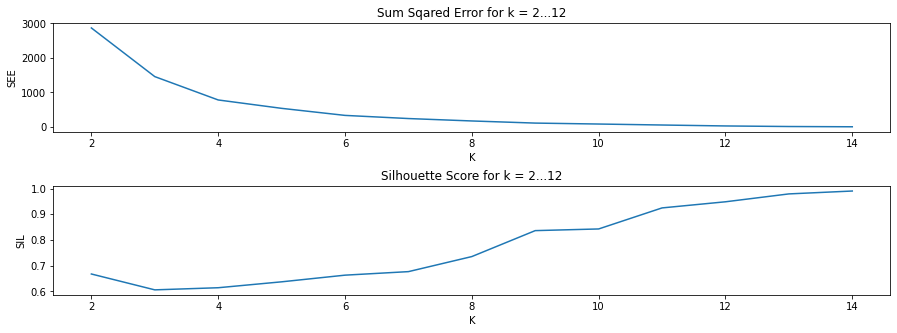

In [25]:
column_name = "PercentSalaryHike"
estimate_column_best_k(column_name)

In [26]:
# best_k = 8
best_k = 4
kmeans_discretizer(column_name, best_k)

PercentSalaryHike	[1]	[15-18]
PercentSalaryHike	[0]	[11-14]
PercentSalaryHike	[3]	[22-25]
PercentSalaryHike	[2]	[19-21]


<h6> TaxRate </h6>

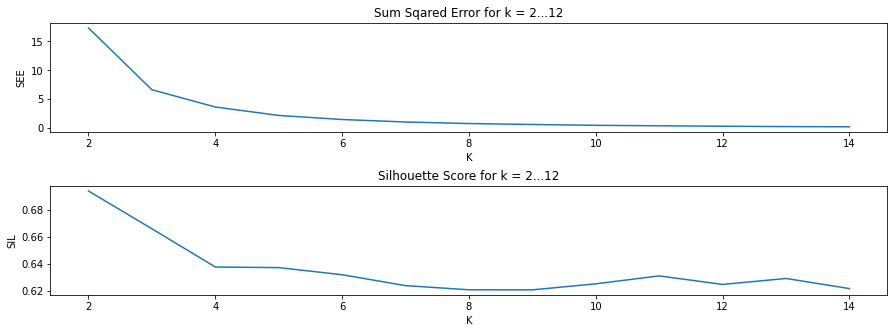

In [27]:
column_name = "TaxRate"
estimate_column_best_k(column_name)

In [28]:
# best_k = 3
best_k = 10
kmeans_discretizer(column_name, best_k)

TaxRate	[3]	[0.2987758224942617-0.38883401777823984]
TaxRate	[4]	[0.3894303660385532-0.476064057549028]
TaxRate	[7]	[0.6633648943918427-0.7497844658672309]
TaxRate	[9]	[0.8350806451612903-0.9513959334891722]
TaxRate	[2]	[0.18591347872720773-0.2893081761006289]
TaxRate	[6]	[0.5716970494267994-0.6611709723484357]
TaxRate	[8]	[0.7518202420560297-0.8349288168875798]
TaxRate	[0]	[0.0-0.06384086648614871]
TaxRate	[5]	[0.4793659860059975-0.5692245229395047]
TaxRate	[1]	[0.0661688446380419-0.18055115616091225]


<h6> OverallSatisfaction </h6>

/home/alexandra/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  
/home/alexandra/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (17). Possibly due to duplicate points in X.
  
/home/alexandra/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (18). Possibly due to duplicate points in X.
  
/home/alexandra/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (19). Possibly due to duplicate points in X.
  
/home/alexandra/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (20). Possibl

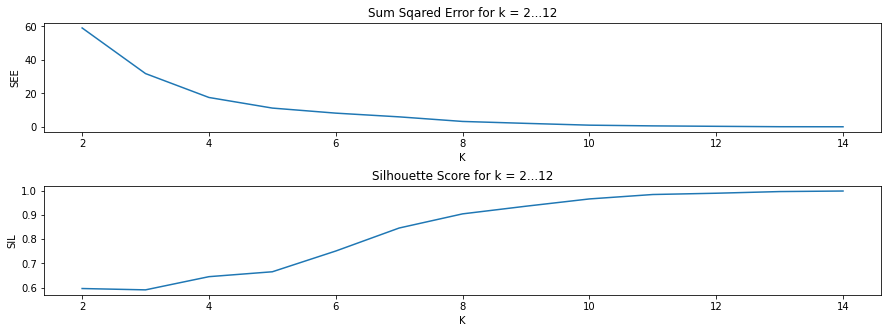

In [29]:
column_name = "OverallSatisfaction"
estimate_column_best_k(column_name)

In [30]:
# best_k = 10
best_k = 7
kmeans_discretizer(column_name, best_k)

OverallSatisfaction	[3]	[2.6-2.8]
OverallSatisfaction	[5]	[3.2-3.4]
OverallSatisfaction	[2]	[2.2-2.4]
OverallSatisfaction	[6]	[3.6-4.0]
OverallSatisfaction	[4]	[3.0-3.0]
OverallSatisfaction	[1]	[1.6-2.0]
OverallSatisfaction	[0]	[1.2-1.4]


<h2> Discretize variables and save them on new file </h2>

In [31]:
discrete_variables = ["DistanceFromHome", "YearsAtCompany", "YearsInCurrentRole", "NumCompaniesWorked",
                      "MonthlyIncome", "PercentSalaryHike", "TaxRate", "Age", "MonthlyHours", "OverallSatisfaction"]
for var in discrete_variables:
    print("train", var, sorted(X_train[var].unique()))
    print("test", var, sorted(X_test[var].unique()))

train DistanceFromHome [0, 1, 2, 3, 4, 5]
test DistanceFromHome [0, 1, 2, 3, 4, 5]
train YearsAtCompany [0, 1, 2, 3, 4]
test YearsAtCompany [0, 1, 2, 3, 4]
train YearsInCurrentRole [0, 1, 2, 3]
test YearsInCurrentRole [0, 1, 2, 3]
train NumCompaniesWorked [0, 1]
test NumCompaniesWorked [0, 1]
train MonthlyIncome [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
test MonthlyIncome [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
train PercentSalaryHike [0, 1, 2, 3]
test PercentSalaryHike [0, 1, 2, 3]
train TaxRate [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
test TaxRate [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
train Age [0, 1, 2, 3, 4, 5]
test Age [0, 1, 2, 3, 4, 5]
train MonthlyHours [0, 1, 2]
test MonthlyHours [0, 1, 2]
train OverallSatisfaction [0, 1, 2, 3, 4, 5, 6]
test OverallSatisfaction [0, 1, 2, 3, 4, 5, 6]


In [32]:
print(X_train.shape)
print(X_test.shape)

(883, 36)
(219, 36)


In [33]:
df1 = X_train.copy()
df2 = X_test.copy()

In [34]:
df1.to_csv(data_directory + "Discretized_Kmeans_One_Hot_Encoding_Train_HR_Employee_Attrition.csv", index=False, header=True)
df2.to_csv(data_directory + "Discretized_Kmeans_One_Hot_Encoding_Test_HR_Employee_Attrition.csv", index=False, header=True)

In [35]:
df_discretized = pd.read_csv(data_directory + "Discretized_Kmeans_One_Hot_Encoding_Train_HR_Employee_Attrition.csv", sep=",") 
df_discretized.shape

(883, 36)

In [36]:
df_discretized = pd.read_csv(data_directory + "Discretized_Kmeans_One_Hot_Encoding_Test_HR_Employee_Attrition.csv", sep=",") 
df_discretized.shape

(219, 36)